# **<center><font color="blue">Human Action Recognition in Videos using Convolutional Neural Networks</font></center>**


## **Project Outline.**

- **`Step 1:` Download and Visualize the Data with its Labels.**

- **`Step 2:` Preprocess and Generate the Training Dataset.**

- **`Step 3:` Split the Data into Train and Test Set.**

- **`Step 4:` Implement the ConvLSTM Approach.**

    - **`Step 4.1:` Construct the Model.**
    
    - **`Step 4.2:` Train the Model.**
    
    - **`Step 4.3:` Plot Model's Loss & Accuracy Curves.**

- **`Step 5:` Implement the LRCN Approach.**
 
    - **`Step 5.1:` Construct the Model.**
    
    - **`Step 5.2:` Train the Model.**
    
    - **`Step 5.3:` Plot Model's Loss & Accuracy Curves.**

- **`Step 6:` Develop a 3D CNN Model for Human Action Recognition.**

    - **`Step 6.1:` Train the Model.**

    - **`Step 6.2:` Plot Model's Loss & Accuracy Curves.**
  
- **`Step 7:` Test the Best Performing Model on YouTube Videos.**

    - **`Step 7.1:` Create a Function to Download YouTube Videos.**

    - **`Step 7.2:` Create a Function To Perform Action Recognition on Videos.**



## **Step 1: Download and Visualize the Dataset with its Labels.**

> [**Human Action Recognition Dataset**](https://web.archive.org/web/20220120114059/https:/www.csc.kth.se/cvap/actions/)

In [ ]:
# Download the Human Action Recognition Dataset.
!wget https://web.archive.org/web/20220120114059/http://www.nada.kth.se/cvap/actions/walking.zip
!wget https://web.archive.org/web/20220120114059/http://www.nada.kth.se/cvap/actions/jogging.zip
!wget https://web.archive.org/web/20220120114059/http://www.nada.kth.se/cvap/actions/running.zip
!wget https://web.archive.org/web/20220120114059/http://www.nada.kth.se/cvap/actions/boxing.zip
!wget https://web.archive.org/web/20220120114059/http://www.nada.kth.se/cvap/actions/handwaving.zip
!wget https://web.archive.org/web/20220120114059/http://www.nada.kth.se/cvap/actions/handclapping.zip

# Make Class Directory.
!mkdir walking
!mkdir jogging
!mkdir running
!mkdir boxing
!mkdir handwaving
!mkdir handclapping

# Extract the Dataset.
!unzip walking.zip -d walking
!unzip jogging.zip -d jogging
!unzip running.zip -d running
!unzip boxing.zip -d boxing
!unzip handwaving.zip -d handwaving
!unzip handclapping.zip -d handclapping

In [ ]:
!pip install youtube-dl moviepy
!pip install git+https://github.com/TahaAnwar/pafy.git

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)4087808/45929032 bytes (8.9%)8192000/45929032 bytes (17.8%)12304384/45929032 bytes (26.8%)15581184/45929032 bytes (33.9%)18481152/45929032 bytes (40.2%)21716992/45929032 bytes (47.3%)25804800/45929032 bytes (56.2%)29982720/45929032 bytes (65.3%)33996800/45929032 bytes (74.0%)38035456/45929032 bytes (82.8%)42156032/45929032 bytes (91.8%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root

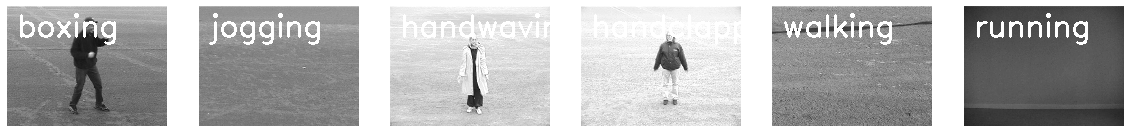

In [3]:
# Import Library.
import os
import cv2
import pafy
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import deque
from moviepy.editor import *
from sklearn.model_selection import train_test_split

# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

# Specify the list containing the names of the classes used for training.
CLASSES_LIST = ["walking", "jogging", "running", "boxing", "handwaving", "handclapping"]

"""
For visualization, we pick all the six categories from the dataset and a random video from each selected category and visualize the 
first frame of the selected videos with their associated labels. This way, we'll be able to represent a subset of the dataset.
"""
plt.figure(figsize=(20, 20))

random_range = random.sample(range(len(CLASSES_LIST)), 6)

for counter, random_index in enumerate(random_range, 1):
    selected_class_Name = CLASSES_LIST[random_index]
    video_files_names_list = os.listdir(f"{selected_class_Name}")
    selected_video_file_name = random.choice(video_files_names_list)
    video_reader = cv2.VideoCapture(f"{selected_class_Name}/{selected_video_file_name}")
    _, bgr_frame = video_reader.read()
    video_reader.release()
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    cv2.putText(
        rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2
    )
    plt.subplot(5, 6, counter)
    plt.imshow(rgb_frame)
    plt.axis("off")

## **Step 2: Preprocess and Generate the Training Dataset.**

In [4]:
def frames_extraction(video_path):
    """
    This function will extract the required frames from a video after resizing and normalizing them.

    Read the video files from the dataset and resize the frames of the videos to a fixed width and height,
    to reduce the computations cost and normalize the data to the range [0-1] by dividing the pixel values by 255,
    which makes convergence faster while training the network.
    """
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)
    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()
        if not success:
            break
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)
    video_reader.release()
    return frames_list


def create_dataset():
    """This function will extract the data of the selected classes and create the required dataset."""
    features = []
    labels = []
    video_files_paths = []
    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f"Extracting Data of Class: {class_name}")
        files_list = os.listdir(class_name)
        for file_name in files_list:
            video_file_path = os.path.join(class_name, file_name)
            frames = frames_extraction(video_file_path)
            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
    features = np.asarray(features)
    labels = np.array(labels)
    return features, labels, video_files_paths


# Utilize the function `create_dataset()` to extract the data of the selected classes and create the required dataset.
features, labels, video_files_paths = create_dataset()

# Using Keras's `to_categorical()` method to convert labels into one-hot-encoded vectors.
one_hot_encoded_labels = tf.keras.utils.to_categorical(labels)

Extracting Data of Class: walking
Extracting Data of Class: jogging
Extracting Data of Class: running
Extracting Data of Class: boxing
Extracting Data of Class: handwaving
Extracting Data of Class: handclapping


## **Step 3: Split the Data into Train and Test Set.**

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    features, one_hot_encoded_labels, test_size=0.25, shuffle=True, random_state=10
)

## **Step 4: Implement the ConvLSTM2D Approach.**

In this step, we will implement a combination of **ConvLSTM** cells. A **ConvLSTM** cell is a variant of an **LSTM** network that contains convolutions operations inside the network. It is an LSTM with convolution embedded in the architecture, making it capable of identifying spatial features of the data while keeping into account the temporal relation.

![ConvLSTM.png](https://miro.medium.com/max/942/1*u8neecA4w6b_F1NgnyPP0Q.png)

For video classification, this approach effectively captures the spatial relation in the individual frames and the temporal relation across the different frames. As a result of this convolution structure, the ConvLSTM is capable of taking in 3-dimensional input `(width, height, num_of_channels)` whereas a simple LSTM only takes in 1-dimensional input. Hence an LSTM is incompatible with modeling Spatio-temporal data on its own.

You can read the paper [**Convolutional LSTM Network: A Machine Learning Approach for Precipitation Nowcasting**](https://arxiv.org/abs/1506.04214v1) by **Xingjian Shi** (NIPS 2015) to learn more about this architecture.


### **Step 4.1: Construct the Model.**

To construct the model, we will use Keras [**`ConvLSTM2D`**](https://keras.io/api/layers/recurrent_layers/conv_lstm2d/) recurrent layers. The **`ConvLSTM2D`** layer also takes in the number of filters and kernel size required for applying the convolutional operations. The output of the layers gets flattened in the end and is passed to the **`Dense`** layer with softmax activation, which outputs the probability of each action category.

We also used the **`MaxPooling3D`** layers to reduce the dimensions of the frames and avoid unnecessary computations and **`Dropout`** layers to prevent overfitting the model on the data. The architecture is simple and has a small number of trainable parameters. It is because we are only dealing with a small subset of the dataset, which does not require a large-scale model.

In [6]:
def convlstm2D_model():
    """
    This function will construct the required ConvLSTM2D model.
    Returns:
        model: It is the required constructed ConvLSTM2D model.
    """
    model = tf.keras.models.Sequential()

    # Define the Model Architecture.
    model.add(
        tf.keras.layers.ConvLSTM2D(
            filters=8,
            kernel_size=(3, 3),
            activation="tanh",
            data_format="channels_last",
            recurrent_dropout=0.2,
            return_sequences=True,
            input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3),
        )
    )
    model.add(
        tf.keras.layers.MaxPooling3D(
            pool_size=(1, 2, 2), padding="same", data_format="channels_last"
        )
    )
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.3)))

    model.add(
        tf.keras.layers.ConvLSTM2D(
            filters=8,
            kernel_size=(3, 3),
            activation="tanh",
            data_format="channels_last",
            recurrent_dropout=0.2,
            return_sequences=True,
        )
    )
    model.add(
        tf.keras.layers.MaxPooling3D(
            pool_size=(1, 2, 2), padding="same", data_format="channels_last"
        )
    )
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.2)))

    model.add(
        tf.keras.layers.ConvLSTM2D(
            filters=16,
            kernel_size=(3, 3),
            activation="tanh",
            data_format="channels_last",
            recurrent_dropout=0.2,
            return_sequences=True,
        )
    )
    model.add(
        tf.keras.layers.MaxPooling3D(
            pool_size=(1, 2, 2), padding="same", data_format="channels_last"
        )
    )
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.2)))

    model.add(
        tf.keras.layers.ConvLSTM2D(
            filters=16,
            kernel_size=(3, 3),
            activation="tanh",
            data_format="channels_last",
            recurrent_dropout=0.2,
            return_sequences=True,
        )
    )
    model.add(
        tf.keras.layers.MaxPooling3D(
            pool_size=(1, 2, 2), padding="same", data_format="channels_last"
        )
    )

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(128, activation="relu", kernel_regularizer="l2"))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(len(CLASSES_LIST), activation="softmax"))

    # Compile the Model.
    model.compile(
        loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"]
    )

    return model

In [7]:
# Utilize the function `convlstm2D_model()` to construct the required ConvLSTM2D Model.
convlstm2D = convlstm2D_model()

# Model Summary.
convlstm2D.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 8)     3200      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 20, 31, 31, 8)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 20, 31, 31, 8)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     4640      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 20, 15, 15, 8)    0         
 3D)                                                             
                                                        

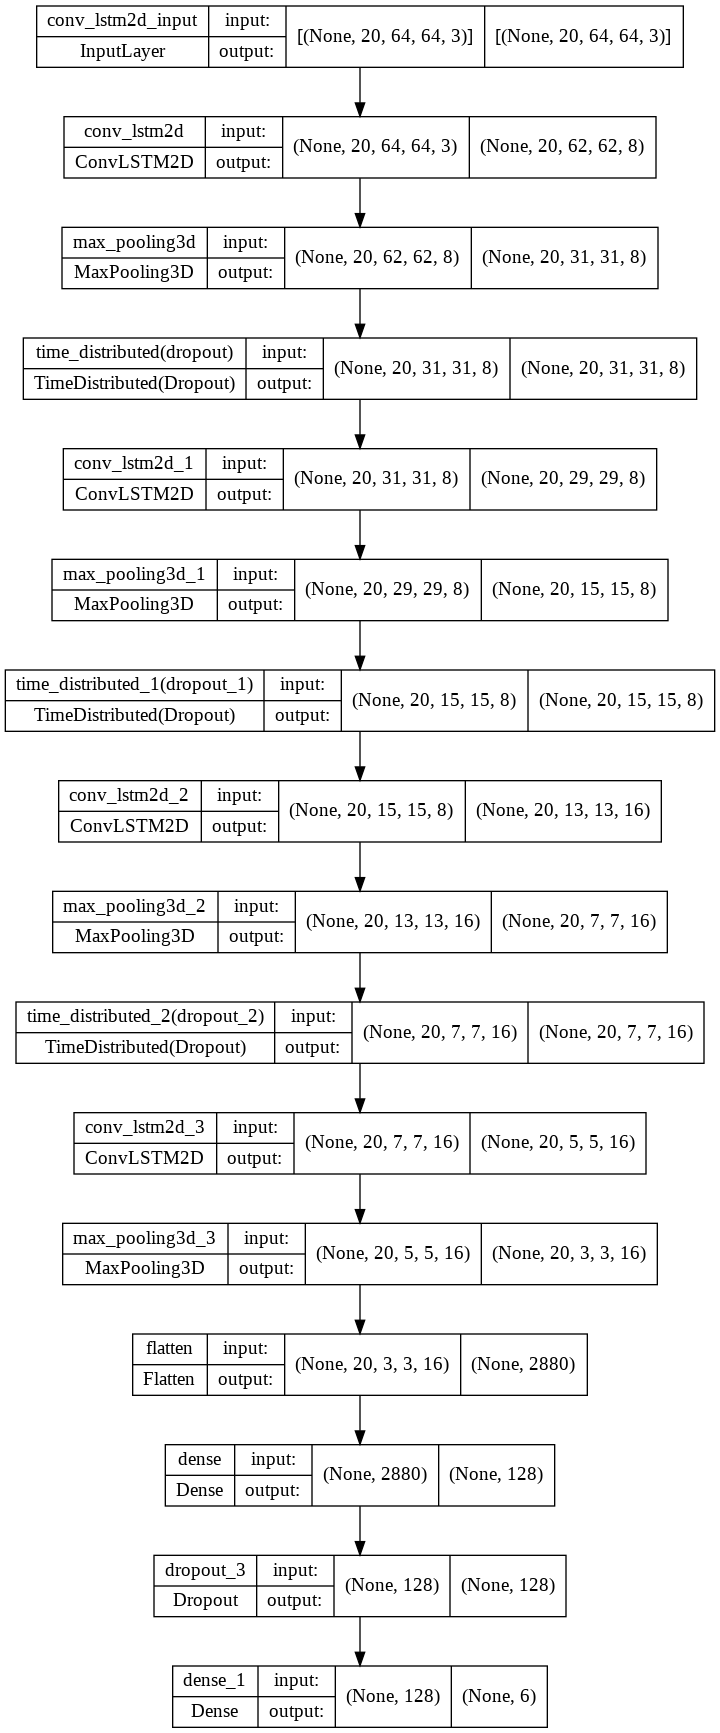

In [8]:
# Plot the Structure of the Constructed Model.
tf.keras.utils.plot_model(
    convlstm2D,
    to_file="convlstm2D_model_plot.png",
    show_shapes=True,
    show_layer_names=True,
)

### **Step 4.2: Train the Model.**

In [9]:
# Fit the Model.
history = convlstm2D.fit(
    x=X_train,
    y=y_train,
    epochs=50,
    batch_size=4,
    validation_data=(X_test, y_test),
    shuffle=True,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=10, mode="min", restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            factor=0.1, patience=10, min_lr=0.00001, verbose=1
        ),
        tf.keras.callbacks.ModelCheckpoint(
            "convlstm2D_action_recognition.h5", verbose=1, save_best_only=True
        ),
    ],
)

Epoch 1/50
90/90 [==============================] - ETA: 0s - loss: 2.4275 - accuracy: 0.1732
Epoch 1: val_loss improved from inf to 1.92523, saving model to convlstm2D_action_recognition.h5
90/90 [==============================] - 69s 531ms/step - loss: 2.4275 - accuracy: 0.1732 - val_loss: 1.9252 - val_accuracy: 0.1556 - lr: 0.0010
Epoch 2/50
90/90 [==============================] - ETA: 0s - loss: 1.8468 - accuracy: 0.1899
Epoch 2: val_loss improved from 1.92523 to 1.79844, saving model to convlstm2D_action_recognition.h5
90/90 [==============================] - 47s 518ms/step - loss: 1.8468 - accuracy: 0.1899 - val_loss: 1.7984 - val_accuracy: 0.3444 - lr: 0.0010
Epoch 3/50
90/90 [==============================] - ETA: 0s - loss: 1.6375 - accuracy: 0.2737
Epoch 3: val_loss improved from 1.79844 to 1.35914, saving model to convlstm2D_action_recognition.h5
90/90 [==============================] - 47s 518ms/step - loss: 1.6375 - accuracy: 0.2737 - val_loss: 1.3591 - val_accuracy: 0.40

### **Step 4.3: Plot Model's Loss & Accuracy Curves.**

In [10]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    """
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object, containing a record of training and validation loss values and metrics values at successive epochs.
        metric_name_1:          The first metric to be plotted in the graph.
        metric_name_2:          The second metric to be plotted in the graph.
        plot_name:              The title of the graph.
    """

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object to be used as the x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, "blue", label=metric_name_1)
    plt.plot(epochs, metric_value_2, "red", label=metric_name_2)

    # Add the title to the Plot.
    plt.title(str(plot_name))
    plt.xlabel("No. of Epochs")
    plt.ylabel("Validation Accuracy/Loss.")

    # Add a legend to the Plot.
    plt.legend()

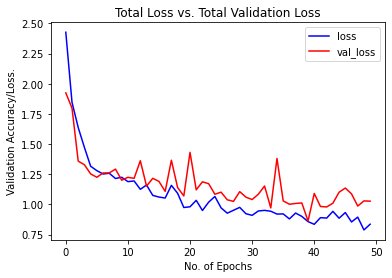

In [11]:
# Visualize the training and validation loss metrics.
plot_metric(history, "loss", "val_loss", "Total Loss vs. Total Validation Loss")

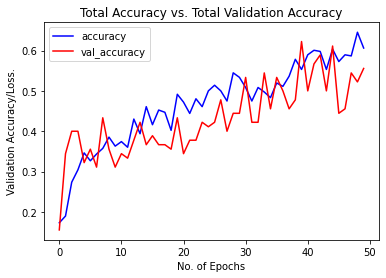

In [12]:
# Visualize the training and validation accuracy metrics.
plot_metric(history, "accuracy", "val_accuracy", "Total Accuracy vs. Total Validation Accuracy")

## **Step 5: Implement the LRCN Approach.**

We also implement the LRCN Approach by combining Convolution and LSTM layers in a single model. Another similar approach is to use CNN and LSTM models trained separately. The CNN model can be used to extract spatial features from the frames in the video, and for this purpose, a pre-trained model can be fine-tuned. And finally, the LSTM model can then use the features extracted by CNN to predict the action performed in the video.

But in this solution, we implement another approach known as the Long-term Recurrent Convolutional Network (LRCN), which combines CNN and LSTM layers in a single model. The Convolutional layers capture the spatial feature extraction from the frames, and then the extracted spatial features are fed to the LSTM layer(s) at each time-steps for temporal sequence modeling. This way, the network learns spatiotemporal features directly in an end-to-end training, resulting in a robust model.

![LRCN.png](https://kobiso.github.io//assets/images/lrcn_tasks.png)

You can read the paper [Long-term Recurrent Convolutional Networks for Visual Recognition and Description](https://arxiv.org/abs/1411.4389) by Jeff Donahue (CVPR 2015) to learn more about this architecture.

We also used the [**`TimeDistributed`**](https://keras.io/api/layers/recurrent_layers/time_distributed/) wrapper layer, which allows applying the same layer to every frame of the video independently. So it makes a layer capable of taking input of shape `(no_of_frames, width, height, num_of_channels)` if originally the layer's input shape was `(width, height, num_of_channels)`, which is very beneficial as it allows to input the whole video into the model in a single shot.

### **Step 5.1: Construct the Model.**

To implement the LRCN architecture, we will use time-distributed **`Conv2D`** layers followed by **`MaxPooling2D`** and **`Dropout`** layers. The feature extracted from the **`Conv2D`** layers will then be flattened using the  **`Flatten`** layer and finally gets passed to a **`LSTM`** layer. The **`Dense`** layer with softmax activation will then use the output from the **`LSTM`** layer to predict the action being performed.

In [13]:
def LRCN_model():
    """
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    """
    model = tf.keras.models.Sequential()

    # Define the Model Architecture.
    model.add(
        tf.keras.layers.TimeDistributed(
            tf.keras.layers.Conv2D(16, (3, 3), padding="same", activation="relu"),
            input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3),
        )
    )
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((4, 4))))
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.4)))

    model.add(
        tf.keras.layers.TimeDistributed(
            tf.keras.layers.Conv2D(32, (3, 3), padding="same", activation="relu")
        )
    )
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((4, 4))))
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.4)))

    model.add(
        tf.keras.layers.TimeDistributed(
            tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation="relu")
        )
    )
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2, 2))))
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.4)))

    model.add(
        tf.keras.layers.TimeDistributed(
            tf.keras.layers.Conv2D(32, (3, 3), padding="same", activation="relu")
        )
    )
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2, 2))))

    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()))

    model.add(tf.keras.layers.LSTM(32))
    model.add(tf.keras.layers.Dense(len(CLASSES_LIST), activation="softmax"))

    # Compile the Model.
    model.compile(
        loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"]
    )

    return model

In [14]:
# Utilize the function `LRCN_model()` to construct the required LRCN Model.
lrcn = LRCN_model()

# Model Summary.
lrcn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, 20, 64, 64, 16)   448       
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 20, 16, 16, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 20, 4, 4, 32)    

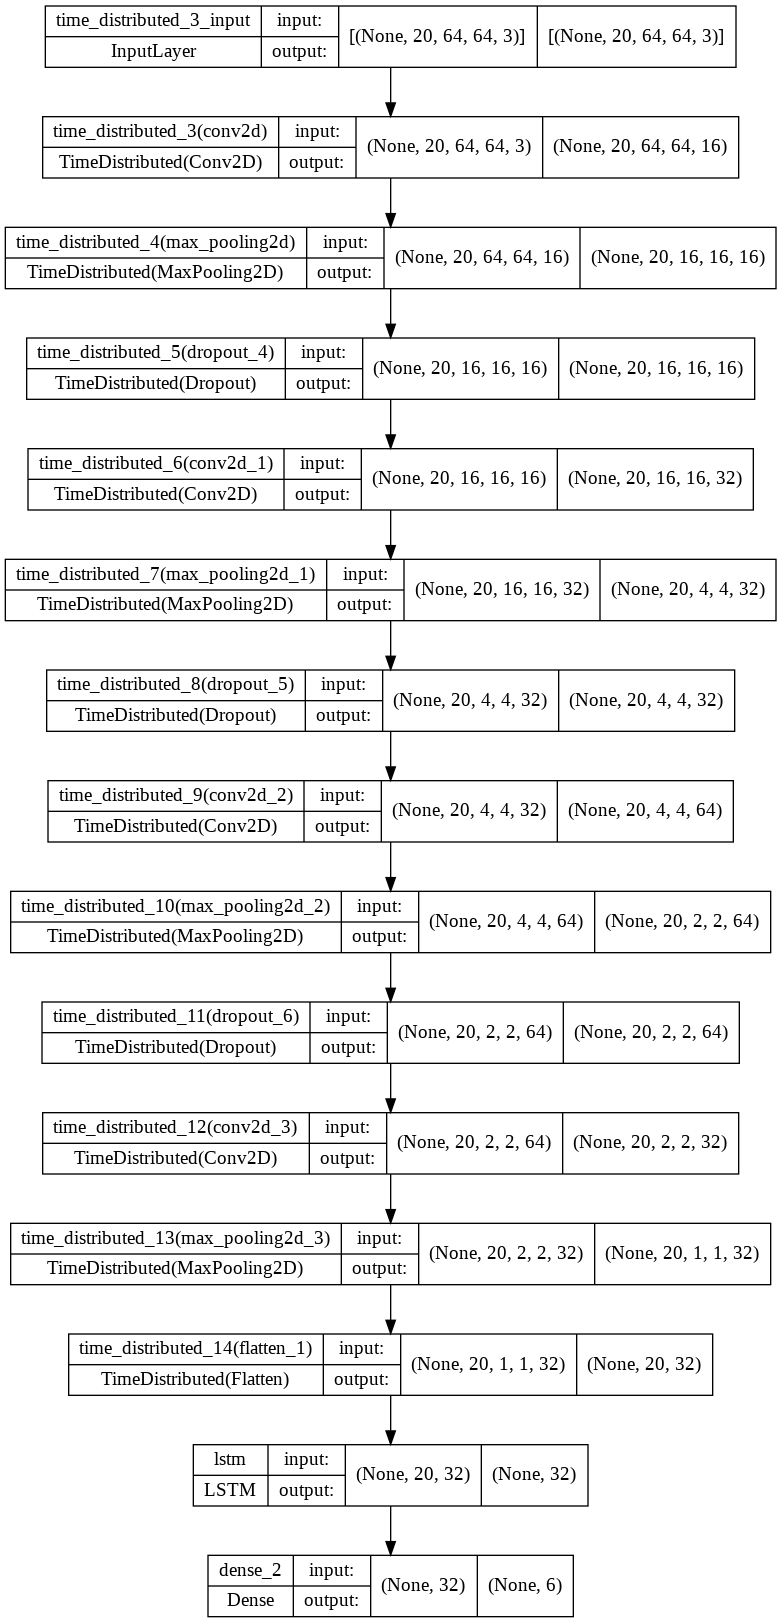

In [15]:
# Plot the Structure of the Constructed Model.
tf.keras.utils.plot_model(
    lrcn, to_file="LRCN_model_plot.png", show_shapes=True, show_layer_names=True
)

### **Step 5.2: Train the Model.**

In [16]:
# Fit the Model.
history = lrcn.fit(
    x=X_train,
    y=y_train,
    epochs=100,
    batch_size=4,
    validation_data=(X_test, y_test),
    shuffle=True,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=10, mode="min", restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            factor=0.1, patience=10, min_lr=0.00001, verbose=1
        ),
        tf.keras.callbacks.ModelCheckpoint(
            "LRCN_action_recognition.h5", verbose=1, save_best_only=True
        ),
    ],
)

Epoch 1/100
90/90 [==============================] - ETA: 0s - loss: 1.8092 - accuracy: 0.1564
Epoch 1: val_loss improved from inf to 1.79412, saving model to LRCN_action_recognition.h5
90/90 [==============================] - 5s 19ms/step - loss: 1.8092 - accuracy: 0.1564 - val_loss: 1.7941 - val_accuracy: 0.0889 - lr: 0.0010
Epoch 2/100
89/90 [============================>.] - ETA: 0s - loss: 1.7949 - accuracy: 0.1826
Epoch 2: val_loss did not improve from 1.79412
90/90 [==============================] - 1s 10ms/step - loss: 1.7949 - accuracy: 0.1816 - val_loss: 1.7966 - val_accuracy: 0.0889 - lr: 0.0010
Epoch 3/100
87/90 [============================>.] - ETA: 0s - loss: 1.7908 - accuracy: 0.1724
Epoch 3: val_loss improved from 1.79412 to 1.77734, saving model to LRCN_action_recognition.h5
90/90 [==============================] - 1s 10ms/step - loss: 1.7901 - accuracy: 0.1704 - val_loss: 1.7773 - val_accuracy: 0.3000 - lr: 0.0010
Epoch 4/100
87/90 [============================>.] - 

### **Step 5.3: Plot Model's Loss & Accuracy Curves.**

*We will utilize the function **`plot_metric()`** created above to visualize and understand the training and validation metrics of this model.*

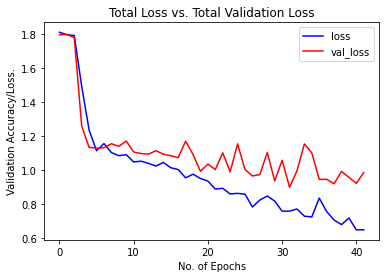

In [17]:
# Visualize the training and validation loss metrics.
plot_metric(history, "loss", "val_loss", "Total Loss vs. Total Validation Loss")

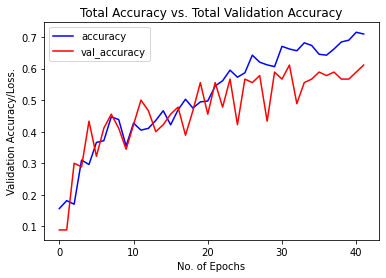

In [18]:
# Visualize the training and validation accuracy metrics.
plot_metric(history, "accuracy", "val_accuracy", "Total Accuracy vs. Total Validation Accuracy")

## **Step 6: Develop a 3D CNN Model for Human Action Recognition.**

3D Convolution [**`Conv3D`**](https://keras.io/api/layers/convolution_layers/convolution3d/) applies a 3-dimensional filter on the 3D dataset. In this, a 3D filter moves in 3 direction (x, y, z) and calculate low-level feature representation. As input is 3-dimensional, the output is also 3-dimensional.

In [33]:
def Conv3D_model(INPUT_SHAPE):
    """This function will construct the required 3D-Convolution Architecture."""

    model = tf.keras.models.Sequential()

    model.add(
        tf.keras.layers.Conv3D(
            filters=64,
            kernel_size=(3, 3, 3),
            padding="valid",
            activation="relu",
            input_shape=INPUT_SHAPE,
        )
    )
    model.add(
        tf.keras.layers.MaxPooling3D(
            pool_size=(3, 3, 3), padding="valid", data_format="channels_last"
        )
    )
    model.add(tf.keras.layers.Dropout(0.4))

    model.add(
        tf.keras.layers.Conv3D(
            filters=32, kernel_size=(3, 3, 3), padding="valid", activation="relu"
        )
    )
    model.add(
        tf.keras.layers.MaxPooling3D(
            pool_size=(3, 3, 3), padding="valid", data_format="channels_last"
        )
    )
    model.add(tf.keras.layers.Dropout(0.4))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(128, activation="relu", kernel_regularizer="l2"))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(len(CLASSES_LIST), activation="softmax"))

    # Compile the Model.
    model.compile(
        loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"]
    )

    return model

In [34]:
# Utilize the function `Conv3D_model()` to construct the required 3D-Convolution Model.
cnn3d = Conv3D_model(X_train.shape[1:])

# Model Summary.
cnn3d.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 18, 62, 62, 64)    5248      
                                                                 
 max_pooling3d_13 (MaxPoolin  (None, 6, 20, 20, 64)    0         
 g3D)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 6, 20, 20, 64)     0         
                                                                 
 conv3d_10 (Conv3D)          (None, 4, 18, 18, 32)     55328     
                                                                 
 max_pooling3d_14 (MaxPoolin  (None, 1, 6, 6, 32)      0         
 g3D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 1, 6, 6, 32)      

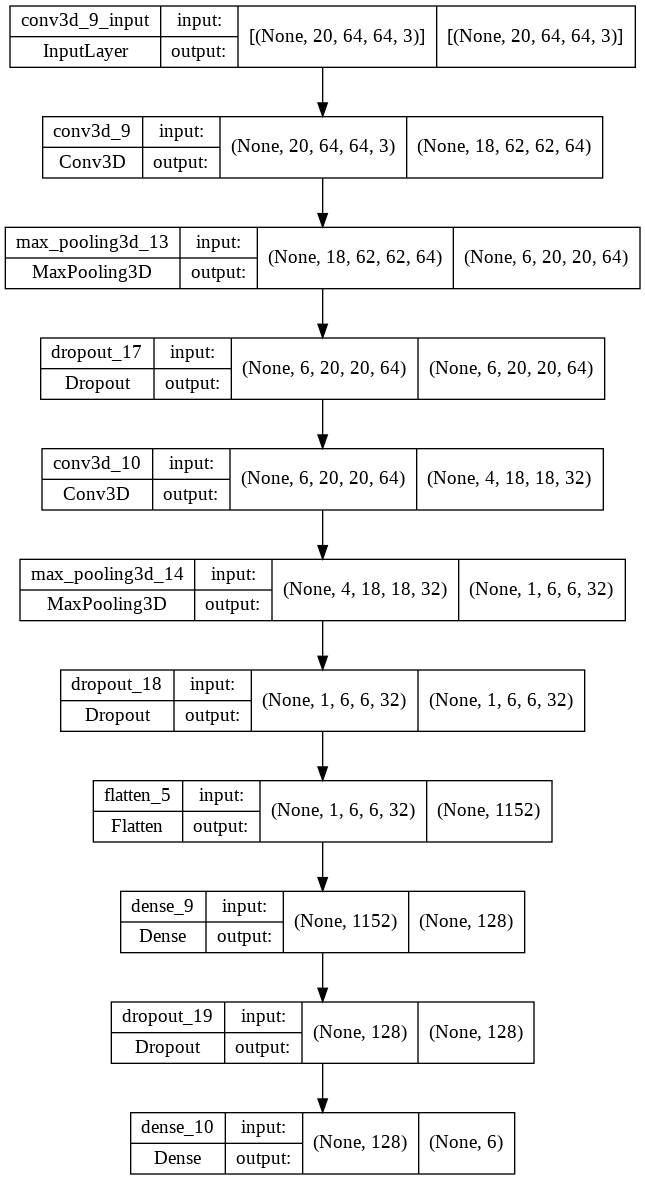

In [35]:
# Plot the Structure of the Constructed Model.
tf.keras.utils.plot_model(
    cnn3d, to_file="cnn3d_model_plot.png", show_shapes=True, show_layer_names=True
)

### **Step 6.1: Train the Model.**

In [36]:
# Fit the Model.
history = cnn3d.fit(
    x=X_train,
    y=y_train,
    epochs=100,
    batch_size=4,
    validation_data=(X_test, y_test),
    shuffle=True,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=20, mode="min", restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            factor=0.1, patience=20, min_lr=0.00001, verbose=1
        ),
        tf.keras.callbacks.ModelCheckpoint(
            "cnn3d_action_recognition.h5", verbose=1, save_best_only=True
        ),
    ],
)

Epoch 1/100
88/90 [============================>.] - ETA: 0s - loss: 3.1145 - accuracy: 0.1307
Epoch 1: val_loss improved from inf to 2.53869, saving model to cnn3d_action_recognition.h5
90/90 [==============================] - 3s 25ms/step - loss: 3.1046 - accuracy: 0.1313 - val_loss: 2.5387 - val_accuracy: 0.0889 - lr: 0.0010
Epoch 2/100
88/90 [============================>.] - ETA: 0s - loss: 2.3480 - accuracy: 0.1335
Epoch 2: val_loss improved from 2.53869 to 2.17616, saving model to cnn3d_action_recognition.h5
90/90 [==============================] - 2s 21ms/step - loss: 2.3454 - accuracy: 0.1313 - val_loss: 2.1762 - val_accuracy: 0.1333 - lr: 0.0010
Epoch 3/100
88/90 [============================>.] - ETA: 0s - loss: 2.0785 - accuracy: 0.1733
Epoch 3: val_loss improved from 2.17616 to 1.99573, saving model to cnn3d_action_recognition.h5
90/90 [==============================] - 2s 21ms/step - loss: 2.0771 - accuracy: 0.1732 - val_loss: 1.9957 - val_accuracy: 0.0889 - lr: 0.0010
Ep

### **Step 6.2: Plot Model's Loss & Accuracy Curves.**

*We will utilize the function **`plot_metric()`** created above to visualize and understand the training and validation metrics of this model.*

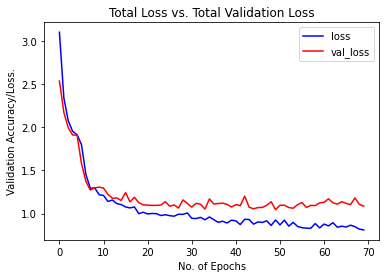

In [37]:
# Visualize the training and validation loss metrics.
plot_metric(history, "loss", "val_loss", "Total Loss vs. Total Validation Loss")

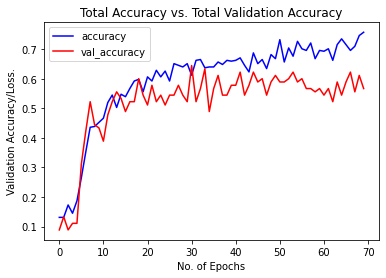

In [38]:
# Visualize the training and validation accuracy metrics.
plot_metric(history, "accuracy", "val_accuracy", "Total Accuracy vs. Total Validation Accuracy")

## **Step 7: Test the Best Performing Model on YouTube Videos.**

*From the prediction results, the ConvLSTM2D model performed significantly well for the given number of classes. So in this step, we use the ConvLSTM2D model to test some YouTube videos.*


In [ ]:
# Load the ConvLSTM2D Model.
convlstm2D = tf.keras.models.load_model("convlstm2D_action_recognition.h5")

### **Step 7.1: Create a Function to Download YouTube Videos.**

In [ ]:
def download_youtube_videos(youtube_video_url, output_directory):
    """
    This function downloads the YouTube video using the pafy library whose URL is passed to it as an argument.
    """

    # Create a video object which contains useful information about the video.
    video = pafy.new(youtube_video_url)

    # Retrieve the title of the video.
    title = video.title

    # Get the best available quality object for the video.
    video_best = video.getbest()

    # Construct the output file path.
    output_file_path = f"{output_directory}/{title}.mp4"

    # Download the YouTube video at the best available quality and store it on the constructed path.
    video_best.download(filepath=output_file_path, quiet=True)

    # Return the video title.
    return title


"""
-------------------------------
    Download a Test Video.
-------------------------------

Utilize the function `download_youtube_videos()` to download a YouTube video on which the ConvLSTM2D model will be tested.
"""

# Make the output directory if it does not exist.
test_videos_directory = "test_videos"
os.makedirs(test_videos_directory, exist_ok=True)

# Download a YouTube Video.
video_title = download_youtube_videos(
    "https://www.youtube.com/watch?v=m9NBE6yCXGE", test_videos_directory
)

# Get the YouTube Video path we just downloaded.
input_video_file_path = f"{test_videos_directory}/{video_title}.mp4"

### **Step 7.2: Create a Function To Perform Action Recognition on Videos.**

In [ ]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    """
    This function will read a video frame by frame from the path passed in an
    argument and will perform action recognition on the video and save the results.
    """

    # Function to perform action recognition on a video using the ConvLSTM2D model.
    video_reader = cv2.VideoCapture(video_file_path)
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    video_writer = cv2.VideoWriter(
        output_file_path,
        cv2.VideoWriter_fourcc("M", "P", "4", "V"),
        video_reader.get(cv2.CAP_PROP_FPS),
        (original_video_width, original_video_height),
    )

    frames_queue = deque(maxlen=SEQUENCE_LENGTH)
    predicted_class_name = ""

    while video_reader.isOpened():
        ok, frame = video_reader.read()
        if not ok:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_queue.append(normalized_frame)

        if len(frames_queue) == SEQUENCE_LENGTH:
            predicted_labels_probabilities = convlstm2D.predict(
                np.expand_dims(frames_queue, axis=0)
            )[0]
            predicted_label = np.argmax(predicted_labels_probabilities)
            predicted_class_name = CLASSES_LIST[predicted_label]

        cv2.putText(
            frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2
        )
        video_writer.write(frame)

    video_reader.release()
    video_writer.release()


"""
-----------------------------------------------------
    Perform Action Recognition on the Test Video.
-----------------------------------------------------

Utilize the function `predict_on_video()` to perform action recognition on the 
test video that we had downloaded using the function `download_youtube_videos()` 
and display the output video with the predicted action overlayed on it.
"""

# Construct the output video path.
output_video_file_path = (
    f"{test_videos_directory}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4"
)

# Perform Action Recognition on the Test Video.
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

# Display the output video.
VideoFileClip(
    output_video_file_path, audio=False, target_resolution=(300, None)
).ipython_display(maxduration=300)